# Covid-19 Classification
Dataset - https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/code

In [44]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
import cv2
import matplotlib.pyplot as plt
import PIL.Image as img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping


In [9]:
train_dir = 'Covid19-dataset/train'
test_dir = 'Covid19-dataset/test'

In [10]:
x_train = []
for folder in os.listdir(train_dir):
    sub_path = train_dir + '/' + folder
    for image in os.listdir(sub_path):
        img_path = sub_path + '/' + image
        img = cv2.imread(img_path)
        img = cv2.resize(img,(224,224)) #VGG19 needs an input of shape 224x224
        x_train.append(img)

In [11]:
x_test = []
for folder in os.listdir(test_dir):
    sub_test = test_dir + '/' + folder
    for image in os.listdir(sub_test):
        img_test = sub_test + '/' + image
        imgtest = cv2.imread(img_test)
        imgtest = cv2.resize(imgtest,(224,224))
        x_test.append(imgtest)

In [12]:
train = np.array(x_train)/255.0
test = np.array(x_test)/255.0

In [13]:
train_data = ImageDataGenerator(rescale = 1/255.0 , validation_split=0.2)
test_data = ImageDataGenerator(rescale = 1/255.0)

In [29]:
train_set = train_data.flow_from_directory(
                    train_dir,
                    subset = 'training',
                    batch_size=32,
                    target_size=(224,224),
                    class_mode = 'sparse'
)
val_set = train_data.flow_from_directory(
                    train_dir,
                    subset = 'validation',
                    batch_size=32,
                    target_size=(224,224),
                    class_mode = 'sparse'
)
test_set = test_data.flow_from_directory(
                    test_dir,
                    batch_size=32,
                    target_size=(224,224),
                    class_mode = 'sparse'
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [30]:
y_train = train_set.classes 
y_val = val_set.classes
y_test = test_set.classes 
print(train_set.class_indices)

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


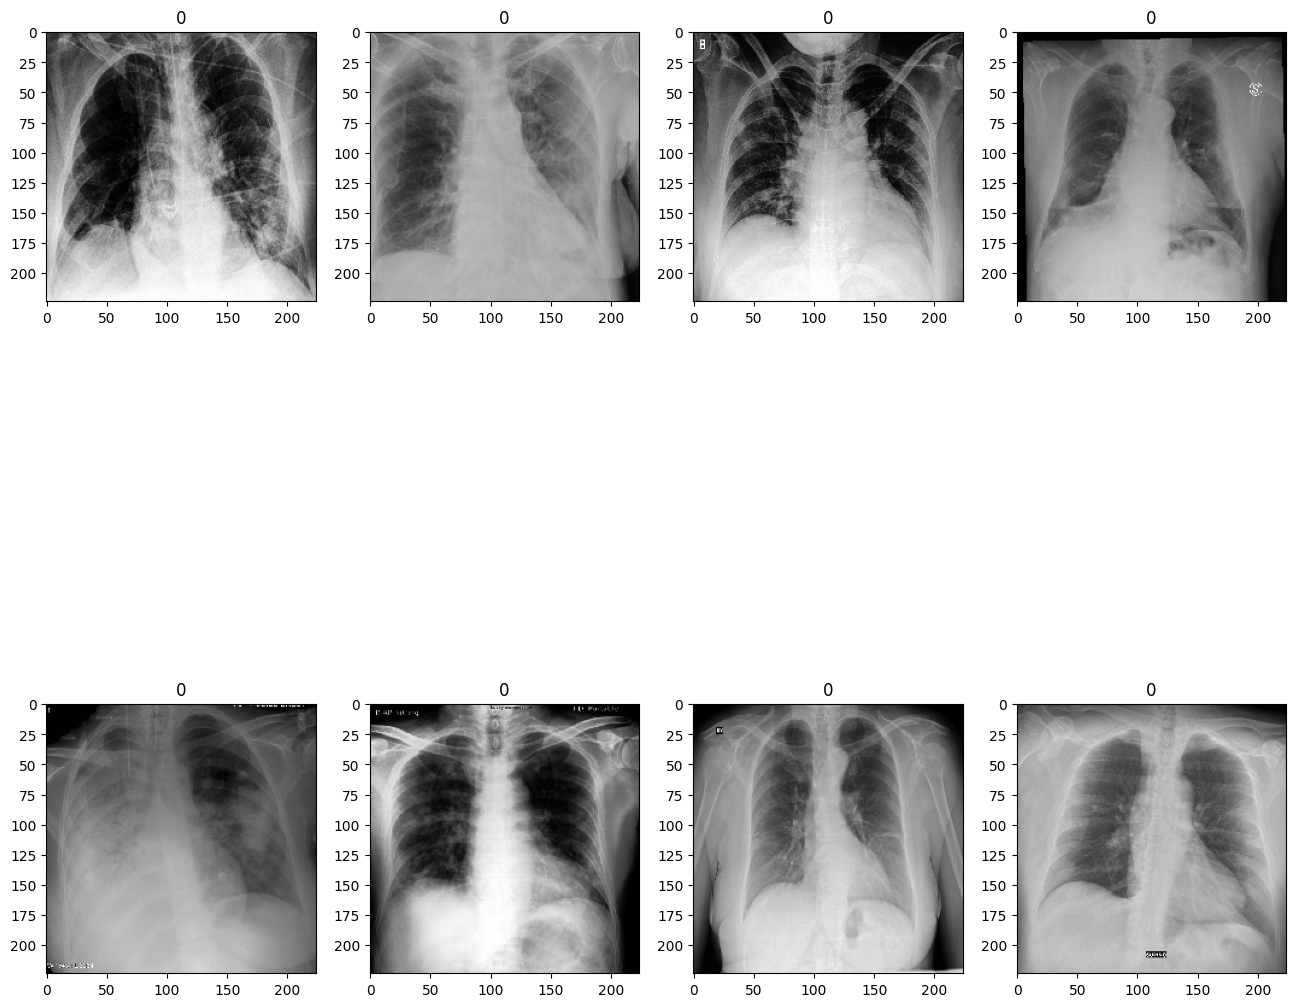

In [16]:
plt.figure(figsize=(16,16))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(train[i])
    plt.title(y_train[i])

In [31]:
vgg = VGG19(include_top = False , input_shape = (224,224,3),weights='imagenet')
for layer in vgg.layers :
    layer.trainable = False

In [18]:
ES = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    min_delta = 0.001,
    verbose = 0
)
model = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.2),
    vgg,
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [20]:
training = model.fit_generator(
    train_set,
    callbacks=[ES],
    steps_per_epoch = 7 ,
    epochs = 10,
    validation_data = val_set
)

/tmp/ipykernel_31298/4287906509.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training = model.fit_generator(


Epoch 1/10


2023-04-03 08:41:38.108888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 70s 11s/step - loss: 0.7025 - accuracy: 0.7711 - val_loss: 0.5681 - val_accuracy: 0.8200
Epoch 2/10
7/7 [==============================] - 74s 11s/step - loss: 0.4827 - accuracy: 0.8060 - val_loss: 0.5722 - val_accuracy: 0.7600
Epoch 3/10
7/7 [==============================] - 65s 9s/step - loss: 0.4014 - accuracy: 0.8607 - val_loss: 0.4715 - val_accuracy: 0.7600
Epoch 4/10
7/7 [==============================] - 78s 11s/step - loss: 0.3698 - accuracy: 0.8458 - val_loss: 0.4263 - val_accuracy: 0.8600
Epoch 5/10
7/7 [==============================] - 67s 10s/step - loss: 0.2746 - accuracy: 0.9204 - val_loss: 0.3718 - val_accuracy: 0.7800
Epoch 6/10
7/7 [==============================] - 75s 12s/step - loss: 0.1863 - accuracy: 0.9353 - val_loss: 0.3166 - val_accuracy: 0.8800
Epoch 7/10
7/7 [==============================] - 66s 9s/step - loss: 0.1598 - accuracy: 0.9552 - val_loss: 0.4077 - val_accuracy: 0.7600
Epoch 8/10
7/7 [========================

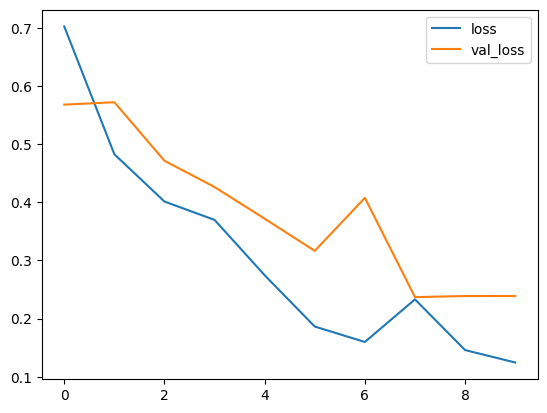

In [21]:
history_df = pd.DataFrame(training.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [23]:
pred = model.predict(test_set)
final_pred = np.argmax(pred, axis =1)
print(final_pred)

2023-04-03 08:55:01.486240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 20s 5s/step
[1 1 2 1 1 2 1 2 0 1 1 0 0 0 2 2 0 0 2 1 1 0 2 2 2 0 0 2 0 2 0 1 1 0 0 0 0
 1 1 1 0 1 1 1 2 0 1 1 0 0 2 2 0 2 0 0 1 1 1 1 0 2 0 2 0 1]


In [33]:
type(final_pred)

numpy.ndarray

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_set.classes
cm = confusion_matrix(true_labels, final_pred)
cr = classification_report(true_labels, final_pred)
print(cm)

[[8 9 9]
 [9 8 3]
 [8 7 5]]


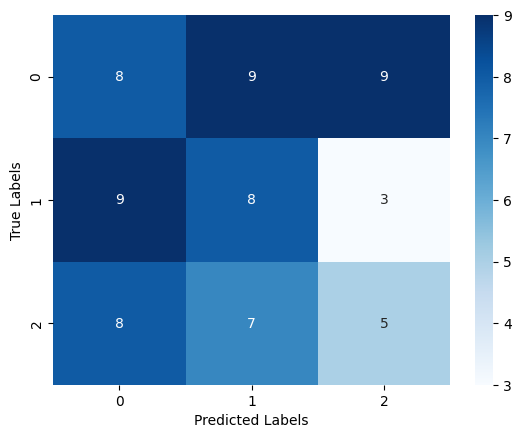

              precision    recall  f1-score   support

           0       0.32      0.31      0.31        26
           1       0.33      0.40      0.36        20
           2       0.29      0.25      0.27        20

    accuracy                           0.32        66
   macro avg       0.32      0.32      0.32        66
weighted avg       0.32      0.32      0.32        66



In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(cr)

